In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()


 Derivative-Free Optimization for Least-Squares (DFO-LS) is a
 nonlinear least-squares solver that only requires function values.

 Documentation
 [https://numericalalgorithmsgroup.github.io/dfols/build/html/index.html](https://numericalalgorithmsgroup.github.io/dfols/build/html/index.html)

 Repository
 [https://github.com/numericalalgorithmsgroup/dfols](https://github.com/numericalalgorithmsgroup/dfols)

 Install using either:
 `conda install -c conda-forge dfo-ls`
 `pip install DFO-LS`

In [3]:
from dfols import solve


In [4]:
# project files
import sys; sys.path.insert(0, '..')

from utils.variables import pack, unpack
from utils.display import table, tabulate
from utils.files import download_sheet, save, load
from utils.hash import digest

from model.fit_options import fit_options, RoundApprox
from model.rp import compute_rp, make_precomputed_columns
from model.initial_guess import make_initial_guess

In [5]:
# stuff for display

from IPython.lib.pretty import pretty, pprint

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# progress bar
from tqdm.auto import tqdm

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 120)

In [6]:
data = pd.read_pickle(fit_options.data_file)
data.describe()
data.head()

,Level,RP,MS lvl,ModelRP,Difference,Freq1,FreqL,Inv,Berry1,BerryL,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,BerryD,IngD,Dupes,Amnt,Ing2P,Help skill bonus,RP Multiplier
count,7459.000000,7459.000000,7459.000000,7459.000000,7459.000000,7459.000000,7459.000000,7459.000000,7459.000000,7459.000000,7459.000000,7459.000000,7459.000000,7459.000000,7459.000000,7459.000000,7459.000000,7459.000000,7459.000000,7459.000000,7459.0,7459.000000,7459.000000,7459.000000,7459.000000
mean,11.177638,634.414801,1.533584,632.102561,-0.002145,3910.470572,3754.056385,12.358225,28.069446,38.371632,108.906422,1.035446,0.988122,0.994691,0.998820,1.007561,0.206735,34.655655,56.051884,148.088350,1.0,0.086339,3.570452,0.986439,1.030142
std,7.416593,413.919870,1.023742,414.554566,0.579664,974.300517,1037.989456,3.481107,2.617833,8.329062,16.181744,0.310829,0.058663,0.045061,0.118037,0.118572,0.046100,38.585297,28.103663,61.384624,0.0,0.555139,22.215128,0.039252,0.072497
min,1.000000,245.000000,1.000000,-1.000000,-21.000000,2200.000000,1489.118400,7.000000,24.000000,24.000000,90.000000,0.520000,0.890000,0.920000,0.800000,0.800000,0.000000,0.000000,25.000000,90.000000,1.0,0.000000,0.000000,0.790000,1.000000
25%,5.000000,360.000000,1.000000,359.000000,0.000000,3100.000000,2904.660000,10.000000,26.000000,33.000000,98.000000,0.810000,1.000000,1.000000,1.000000,1.000000,0.180000,13.160000,36.000000,101.000000,1.0,0.000000,0.000000,1.000000,1.000000
50%,10.000000,489.000000,1.000000,488.000000,0.000000,3800.000000,3731.600000,12.000000,28.000000,37.000000,103.000000,0.960000,1.000000,1.000000,1.000000,1.000000,0.200000,20.200000,46.000000,121.000000,1.0,0.000000,0.000000,1.000000,1.000000
75%,14.000000,748.000000,2.000000,745.000000,0.000000,4500.000000,4419.000000,14.000000,31.000000,42.000000,115.000000,1.230000,1.000000,1.000000,1.000000,1.000000,0.230000,47.830000,68.000000,202.000000,1.0,0.000000,0.000000,1.000000,1.000000
max,42.000000,3493.000000,6.000000,3495.000000,5.000000,6300.000000,6916.140000,24.000000,35.000000,83.000000,151.000000,2.410000,1.120000,1.080000,1.200000,1.200000,0.420000,414.090000,243.000000,511.000000,1.0,8.000000,342.000000,1.000000,1.440000


,Pokemon,Level,RP,Nature,MS lvl,Source,ModelRP,Difference,Nature2,ID,NatureP,NatureN,Freq1,FreqL,Type,Class,MSkill,Inv,Berry1,BerryL,Ing1,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,RPneutral,IDNeutral,BerryD,IngD,Dupes,DupeMatch,Sub Skill 1,Sub Skill 2,Ingredient 2,Amnt,Ing2P,Help skill bonus,RP Multiplier
0,Arbok,9.0,574.0,Naughty,1.0,Rate My Mon,574.0,0.0,Naughty,ArbokNaughty91,Speed of Help,Main Skill Chance,3700.0,3276.72,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,1.09,0.9,1.00,1.0,0.8,0.26,22.75,538.35,ArbokNeutral91,80.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
1,Arbok,8.0,531.0,Hardy,1.0,Questions help guides,531.0,0.0,Neutral,ArbokNeutral81,-,-,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.0,1.00,1.0,1.0,0.26,22.75,531.00,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
2,Arbok,8.0,538.0,Quiet,1.0,Questions help guides,538.0,0.0,Quiet,ArbokQuiet81,Ingredient Finding,Exp Gains,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.0,1.00,1.2,1.0,0.26,22.75,530.60,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
3,Arbok,9.0,582.0,Relaxed,1.0,,582.0,0.0,Relaxed,ArbokRelaxed91,Energy Recovery,EXP Gains,3700.0,3640.80,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,0.98,1.0,1.08,1.0,1.0,0.26,22.75,538.89,ArbokNeutral91,80.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
4,Arbok,9.0,489.0,Timid,1.0,,489.0,0.0,Timid,ArbokTimid91,EXP Gains,Speed of Help,3700.0,4004.88,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,0.89,1.1,1.00,1.0,1.0,0.26,22.75,538.45,ArbokNeutral91,80.0,103.0,1,True,,,,0.0,0.0,1.0,1.0


In [7]:
# Use exact rounding for this worksheet

fit_options.rounding.final_rp = RoundApprox.Exact
fit_options.rounding.bonus = RoundApprox.Exact
fit_options.rounding.period = RoundApprox.Exact
fit_options.rounding.components = RoundApprox.Pass

#fit_options.rounding.period = RoundApprox.Pass
#fit_options.rounding.components = RoundApprox.Pass




In [8]:
# Make an initial guess
# Pack the dictionary into a 1-D vector.
# Also store information on how to unpack that vector

x0, unpack_info = pack(*make_initial_guess())
computed = make_precomputed_columns(data)

In [9]:
# We compute the RP model in rp_model.py
# Here we create closure to glue the pieces together.

def RP(x):
    return compute_rp(x, data, computed, unpack_info)

# for the error analysis page,
# we'll compute the residual with exact rounding.

def residual(x):
    return data["RP"] - np.round(RP(x))


In [10]:
filename = fit_options.result_file(digest(data, x0))
opt = load(filename)
opt

    message: `ftol` termination condition is satisfied.
    success: True
     status: 2
          x: [ 5.636e-01  5.439e-01 ...  3.668e-01  3.702e-01]
       cost: 901.1976174520792
       grad: [-1.433e-05 -5.572e-05 ...  0.000e+00  0.000e+00]
 optimality: 0.0030836685255053453
       nfev: 16
       njev: 7

In [11]:

#fit_options.soft_round.alpha = 18

optx = opt.x
#choice_list = [0.5*optx, 1.5*optx]
#bounds_low =  np.select([optx>=0, optx<0], choice_list)
#bounds_high = np.select([optx<0, optx>=0], choice_list)
#result = solve(residual, optx, bounds=( bounds_low, bounds_high ), scaling_within_bounds=True, print_progress=True, maxfun=2200)

result = solve(residual, optx, print_progress=True, maxfun=2200)


 Run  Iter     Obj       Grad     Delta      rho     Evals 
  1     1    1.72e+03  4.94e+04  1.38e-01  1.38e-01   250  
  1     2    1.72e+03  4.94e+04  6.92e-02  1.38e-02   250  
  1     3    1.72e+03  4.95e+04  3.46e-02  1.38e-02   252  
  1     4    1.72e+03  5.06e+04  1.38e-02  1.38e-02   254  
  1     5    1.72e+03  6.59e+04  1.38e-02  1.38e-02   256  
  1     6    1.72e+03  6.07e+04  1.38e-02  1.38e-02   258  
  1     7    1.72e+03  6.01e+04  1.38e-02  1.38e-02   260  
  1     8    1.72e+03  6.31e+04  1.38e-02  1.38e-02   262  
  1     9    1.72e+03  6.50e+04  1.38e-02  1.38e-02   264  
  1    10    1.72e+03  6.71e+04  1.38e-02  1.38e-02   266  
  1    11    1.72e+03  6.82e+04  1.38e-02  1.38e-02   268  
  1    12    1.72e+03  7.35e+04  1.38e-02  1.38e-02   270  
  1    13    1.72e+03  7.34e+04  1.38e-02  1.38e-02   272  
  1    14    1.72e+03  7.21e+04  1.38e-02  1.38e-02   274  
  1    15    1.72e+03  7.14e+04  1.38e-02  1.38e-02   276  
  1    16    1.72e+03  7.97e+04  1.38e-0

In [12]:
table(result)

EXIT_FALSE_SUCCESS_WARNING,3
EXIT_INPUT_ERROR,-1
EXIT_LINALG_ERROR,-3
EXIT_MAXFUN_WARNING,1
EXIT_SLOW_WARNING,2
EXIT_SUCCESS,0
EXIT_TR_INCREASE_ERROR,-2
diagnostic_info,None
f,1693.0
flag,0
jacobian,[[ 0. -0. -0. ... -0. 0. -0.] [ 0. -0. -0. ... -0. 0. -0.] [ 0. -0. -0. ... -0. 0. -0.] ... [ 0. -0. -0. ... -0. 0. -0.] [ 0. -0. -0. ... -0. 0. -0.] [ 0. -0. -0. ... -0. 0. -0.]]


count    7459.000000
mean       -0.005497
std         0.476418
min        -6.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        13.000000
Name: RP, dtype: float64

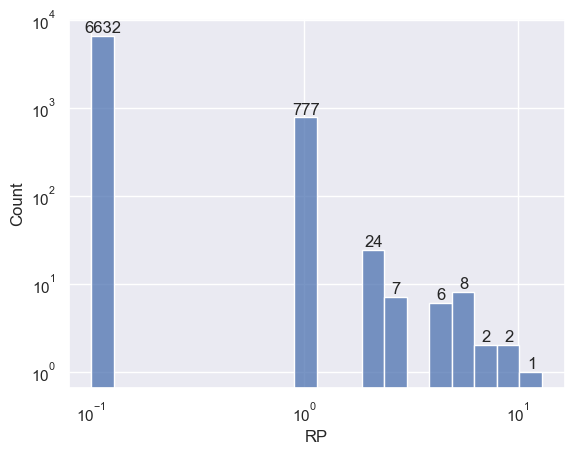

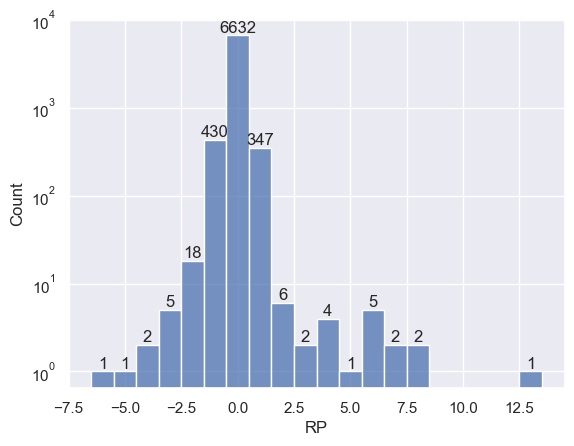

In [13]:
r_opt = data["RP"] - np.round(RP(result.x))
pd.Series(r_opt).describe()

_ = plt.figure()
g = sns.histplot(x=np.clip(np.abs(r_opt), 1e-1,1e3), log_scale=True, bins=20)
g.axes.set_yscale('log')
_ = g.bar_label(g.containers[1], labels= [str(v) if v else '' for v in g.containers[1].datavalues])

_ = plt.figure()
g = sns.histplot(x=r_opt, discrete=1)
_ = g.axes.set_yscale('log')
_ = g.bar_label(g.containers[1], labels= [str(v) if v else '' for v in g.containers[1].datavalues])

In [14]:

# What are the worst points?

df = data[["Pokemon", "ID", "Level", "MS lvl", "NatureP", "NatureN", "Sub Skill 1", "Sub Skill 2", "RP"]].copy()

df["fit"] = RP(result.x)
df["error"] = data["RP"] - np.round(RP(result.x))
df["error2"] = df["error"] ** 2

df = df.sort_values("error2", ascending=False).reset_index(drop=True)
df.head(100)

,Pokemon,ID,Level,MS lvl,NatureP,NatureN,Sub Skill 1,Sub Skill 2,RP,fit,error,error2
0,Glaceon,GlaceonNeutral276Skill Level Up MHelping Speed M,27.0,6.0,-,-,Skill Level Up M,Helping Speed M,2485.0,2472.0,13.0,169.0
1,Charizard,CharizardRash273Helping bonusHelping Speed M,27.0,3.0,Ingredient Finding,Main Skill Chance,Helping bonus,Helping Speed M,1440.0,1432.0,8.0,64.0
2,Charizard,CharizardNeutral273Berry Finding SHelping Speed M,27.0,3.0,-,-,Berry Finding S,Helping Speed M,1528.0,1520.0,8.0,64.0
3,Typhlosion,TyphlosionCareful273Berry Finding SHelping Spe...,27.0,3.0,Main Skill Chance,Ingredient Finding,Berry Finding S,Helping Speed M,1761.0,1754.0,7.0,49.0
4,Charizard,CharizardNeutral273Inventory Up MHelping Speed M,27.0,3.0,-,-,Inventory Up M,Helping Speed M,1299.0,1292.0,7.0,49.0
5,Absol,AbsolHasty171Helping Speed S,17.0,1.0,EXP Gains,Energy Recovery,Helping Speed S,,672.0,666.0,6.0,36.0
6,Flareon,FlareonGentle102Helping Speed S,10.0,2.0,Main Skill Chance,Energy Recovery,Helping Speed S,,849.0,843.0,6.0,36.0
7,Glaceon,GlaceonAdamant265Skill Trigger MSkill Level Up M,26.0,5.0,Speed of Help,Ingredient Finding,Skill Trigger M,Skill Level Up M,2299.0,2305.0,-6.0,36.0
8,Charizard,CharizardMild276Skill Level Up MHelping Speed M,27.0,6.0,Ingredient Finding,Energy Recovery,Skill Level Up M,Helping Speed M,1514.0,1508.0,6.0,36.0
9,Charizard,CharizardMild276Helping Speed MSkill Level Up M,27.0,6.0,Ingredient Finding,Energy Recovery,Helping Speed M,Skill Level Up M,1514.0,1508.0,6.0,36.0
